In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os 
import zipfile

In [5]:
# Make a directory to store the data
os.makedirs("Dataset")

In [6]:
with zipfile.ZipFile("/content/drive/MyDrive/covid-dataset/processed-data.zip", "r") as z_fp:
    z_fp.extractall("./Dataset/")

In [9]:
!ls Dataset/processed-data

train  val


In [10]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(), #data augmentation
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [11]:
#Dataloader

#Path for training and validation directory
train_path='/content/Dataset/processed-data/train'
validation_path='/content/Dataset/processed-data/val'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=1, shuffle=True
)
validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_path,transform=transformer),
    batch_size=1, shuffle=True
)

In [12]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [13]:
print(classes)

['1NonCOVID', '2COVID']


In [14]:
#CNN Network
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Input shape= (256,3,256,256)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,256,256)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,256,256)
        self.relu1=nn.ReLU()
        #Shape= (256,12,256,256)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,128,128)
        
        # Temporarily save the gradient values
        self.gradients = None

        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,128,128)
        self.relu2=nn.ReLU()
        #Shape= (256,20,128,128)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,64,64)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,64,64)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,64,64)
        self.relu3=nn.ReLU()
        #Shape= (256,32,64,64)
        
        
        self.fc=nn.Linear(in_features=64 * 64* 32,out_features=num_classes)
        
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        h = output.register_hook(self.activations_hook)
        output=self.bn1(output)
        output=self.relu1(output)
         
        output=self.pool(output)
  
        output=self.conv2(output)
        h = output.register_hook(self.activations_hook)
        output=self.relu2(output)

        output=self.pool(output)
        
        output=self.conv3(output)
        h = output.register_hook(self.activations_hook)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
        #Above output will be in matrix form, with shape (256,32,64,46)
            
        output=output.view(-1,32*64*64)
            
            
        output=self.fc(output)
            
        return output

  # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

  # method for the activation exctraction
    def get_activations(self, x):
        return self.nn.BatchNorm2d(num_features=x)

In [15]:
model=ConvNet(num_classes=6).to(device)

In [16]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [17]:
num_epochs=10

In [18]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
validation_count=len(glob.glob(validation_path+'/**/*.png'))

In [19]:
print(train_count,validation_count)

11028 2758


In [20]:
#Model training and saving best model
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on validation dataset
    model.eval()
    
    validation_accuracy=0.0
    for i, (images,labels) in enumerate(validation_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        validation_accuracy+=int(torch.sum(prediction==labels.data))
    
    validation_accuracy=validation_accuracy/validation_count

    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Validation Accuracy: '+str(validation_accuracy))
    
    #Save the best model
    if validation_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=validation_accuracy


Epoch: 0 Train Loss: tensor(0.7365) Train Accuracy: 0.8335146898803046 Validation Accuracy: 0.7991298042059464
Epoch: 1 Train Loss: tensor(0.2597) Train Accuracy: 0.8970801595937613 Validation Accuracy: 0.8386511965192168
Epoch: 2 Train Loss: tensor(0.1961) Train Accuracy: 0.9216539717083787 Validation Accuracy: 0.8651196519216824
Epoch: 3 Train Loss: tensor(0.1600) Train Accuracy: 0.9357997823721437 Validation Accuracy: 0.8578680203045685
Epoch: 4 Train Loss: tensor(0.1385) Train Accuracy: 0.9463184620964817 Validation Accuracy: 0.8477157360406091
Epoch: 5 Train Loss: tensor(0.1213) Train Accuracy: 0.9525752629669931 Validation Accuracy: 0.846627991298042
Epoch: 6 Train Loss: tensor(0.1075) Train Accuracy: 0.9581973159231049 Validation Accuracy: 0.869108049311095
Epoch: 7 Train Loss: tensor(0.0991) Train Accuracy: 0.9615524120420748 Validation Accuracy: 0.851341551849166
Epoch: 8 Train Loss: tensor(0.0892) Train Accuracy: 0.9671744649981865 Validation Accuracy: 0.8676577229876722
Epoc

## Inference

In [21]:
best_model = torch.load('/content/best_checkpoint.model')
model = ConvNet(num_classes=6)
model.load_state_dict(best_model)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=131072, out_features=6, bias=True)
)

In [22]:
#Transforms (no data augmentation)
transformer=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [23]:
def tensor_to_imgnumpy(image: torch.Tensor, denormalize=False) -> np.ndarray:
    assert image.dim() == 3, f"expecting [3,256,256], the input size is {image.size()}" 
    
    imgnumpy = image.numpy().transpose(1,2,0)
    if denormalize:
        imgnumpy = imgnumpy*np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.22))
    
    imgnumpy = imgnumpy.clip(0, 1)
    return imgnumpy

Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

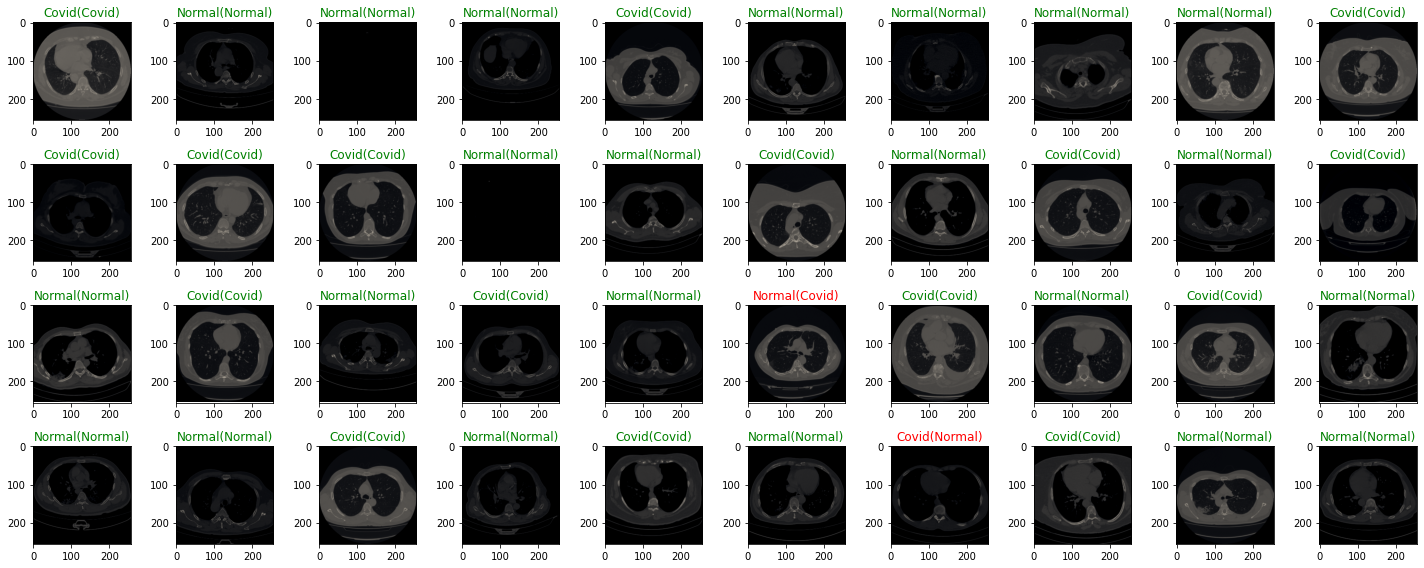

In [24]:
dataset_classes = ['Covid','Normal']

def imshow(imgnumpy: np.ndarray, label, denormalize=False):
    plt.imshow(tensor_to_imgnumpy(imgnumpy,denormalize=denormalize))
    plt.title(dataset_classes[label])
   

plt.figure(figsize=(20, 8))
for idx,(img,label) in enumerate(validation_loader):
    plt.subplot(4,10,idx+1)
    imshow(img[0],label,denormalize=True)
    
    # inference
    try:
        pred = model.forward(img.cuda())
    except Exception as e:
        pred =  model.forward(img)
        print(e)

    title_dataset = dataset_classes[label]
    title_pred = dataset_classes[pred.argmax()]
    plt.title(f"{title_dataset}({title_pred})",color=("green" if title_dataset==title_pred else "red"))
    
    if idx == 40-1:
        break
        
plt.tight_layout()

## Testing

In [33]:
#prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path).convert('RGB')
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred=classes[index]
    
    return pred

In [34]:
from PIL import Image

In [35]:
pred_dict={}

In [37]:
print("Covid Detection using Chest CT Scan")
print("-----------------------------------")

print("Enter image folder path: ")
pred_path = str(input())

#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

#print(classes)

images_path=glob.glob(pred_path+'/*.png')

pred_dict={}

for i in images_path:
  x = pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)

print("Result")
print(pred_dict)

Covid Detection using Chest CT Scan
-----------------------------------
Enter image folder path: 
/content/test
Result
{'P039_146.png': '2COVID', 'P039_160.png': '2COVID', 'P039_118.png': '2COVID', 'P039_95.png': '2COVID', 'P039_105.png': '2COVID'}
